In [ ]:
import logging
from copy import copy
from enum import Enum

import numpy as np
from pydrake.all import (AbstractValue, AddMultibodyPlantSceneGraph, AngleAxis,
                         Concatenate, DiagramBuilder, InputPortIndex,
                         LeafSystem, MeshcatVisualizer, Parser,
                         PiecewisePolynomial, PiecewisePose, PointCloud, RandomGenerator, RigidTransform,
                         RollPitchYaw, Simulator, StartMeshcat,
                         UniformlyRandomRotationMatrix,
                         BsplineTrajectory, Sphere, Rgba,
                         KinematicTrajectoryOptimization, Solve, MinimumDistanceConstraint,
                         PositionConstraint)

from manipulation import FindResource, running_as_notebook
from manipulation.meshcat_utils import AddMeshcatTriad
from manipulation.scenarios import (AddPackagePaths,
                                    MakeManipulationStation, AddIiwa, AddShape, AddWsg, AddMultibodyTriad)
import matplotlib.pyplot as plt
import mpld3
import pydot
from IPython.display import HTML, SVG, display
from pydrake.all import (AbstractValue, AddMultibodyPlantSceneGraph, BaseField,
                         ConstantValueSource, DepthImageToPointCloud,
                         DiagramBuilder, FindResourceOrThrow,
                         MeshcatPointCloudVisualizer, MeshcatVisualizer,
                         MeshcatVisualizerParams, Parser, PointCloud,
                         RigidTransform, RollPitchYaw, RotationMatrix,
                         StartMeshcat)

from manipulation import running_as_notebook
from manipulation.scenarios import (AddMultibodyTriad, AddRgbdSensor,
                                    MakeManipulationStation)
from manipulation.utils import FindResource

if running_as_notebook:
    mpld3.enable_notebook()

class NoDiffIKWarnings(logging.Filter):
    def filter(self, record):
        return not record.getMessage().startswith('Differential IK')

logging.getLogger("drake").addFilter(NoDiffIKWarnings())

In [ ]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://68a898be-bd4e-4046-916a-6293aadf6c5d.deepnoteproject.com/7003/


In [ ]:
squash_ball_radius = 0.02
p_GB_G = [0, 0.07, 0]
def add_target_objects(X_WThrow, X_WCatch):
    # p_ThrowB_W = X_WThrow.rotation() @ p_GB_G
    # X_WThrowB_W = RigidTransform(X_WThrow.rotation(), X_WThrow.translation() +  p_ThrowB_W)
    # p_CatchB_W = X_WCatch.rotation() @ p_GB_G
    # X_WCatchB_W = RigidTransform(X_WCatch.rotation(), X_WCatch.translation() +  p_CatchB_W)
    meshcat.SetObject("throw", Sphere(squash_ball_radius), rgba=Rgba(.9, .1, .1, 1))
    meshcat.SetTransform("throw", X_WThrow)
    meshcat.SetObject("catch", Sphere(squash_ball_radius), rgba=Rgba(.1, .9, .1, 1))
    meshcat.SetTransform("catch", X_WCatch)

q_Throw = np.array([-0.54, 0.58, 0, -1.79, 0, -0.79, 0])
p_WThrow = [0.6, -0.3, 0.39] # [0.55 -0.38 0.39]
R_WThrow = RollPitchYaw([-np.pi, 0.00, 1.10]) #[-3.13 0.00 0.97]

q_Catch = np.array([-0.74, 0.58, 0, -1.79, 0, -0.79, 0])
p_WCatch = [0.50, -0.45, 0.39]
R_WCatch = RollPitchYaw([-np.pi, 0.00, 0.84])

X_WThrow = RigidTransform(R_WThrow, p_WThrow)
X_WCatch = RigidTransform(R_WCatch, p_WCatch)

In [ ]:
def make_kin_traj_opt_trajectory(q_Throw, q_Catch, v_Throw, v_Catch, t_duration):
    # meshcat.Delete()
    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)

    parser = Parser(plant)
    AddPackagePaths(parser)
    iiwa = AddIiwa(plant)
    wsg = AddWsg(plant, iiwa, welded=True, sphere=True)

    num_control_points = 11

    plant.Finalize()

    # visualizer = MeshcatVisualizer.AddToBuilder(
    #     builder, scene_graph, meshcat,
    #     MeshcatVisualizerParams(role=Role.kIllustration))
    # collision_visualizer = MeshcatVisualizer.AddToBuilder(
    #     builder, scene_graph, meshcat,
    #     MeshcatVisualizerParams(prefix="collision", role=Role.kProximity))
    # meshcat.SetProperty("collision", "visible", False)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(context)
    # print(q_Throw)
    plant.SetPositions(plant_context, q_Throw)
    q0 = plant.GetPositions(plant_context)
    # print(q0)
    
    gripper_frame = plant.GetFrameByName("body", wsg)
    trajopt = KinematicTrajectoryOptimization(plant.num_positions(), num_control_points)
    prog = trajopt.get_mutable_prog()

    q_guess = np.tile(q0.reshape((7,1)), (1, trajopt.num_control_points()))
    q_guess[0,:] = np.linspace(-0.54, -0.74, trajopt.num_control_points())
    path_guess = BsplineTrajectory(trajopt.basis(), q_guess)
    trajopt.SetInitialGuess(path_guess)
    
    trajopt.AddPathLengthCost(2)
    # Add cost for acceleration?

    trajopt.AddPositionBounds(plant.GetPositionLowerLimits(),
                              plant.GetPositionUpperLimits())
    trajopt.AddVelocityBounds(plant.GetVelocityLowerLimits(),
                              plant.GetVelocityUpperLimits())

    # trajopt.AddDurationBounds(t_start, t_start + 2 * t_duration) # Assume t_duration each way
    trajopt.AddDurationConstraint(2 * t_duration, 2 * t_duration)
    
    # trajopt.AddEqualTimeIntervalConstraints()

    # Constrain positions in spatial positions
    # start constraint
    start_constraint = PositionConstraint(plant, plant.world_frame(),
                                          X_WThrow.translation(),
                                          X_WThrow.translation(), gripper_frame,
                                          p_GB_G, plant_context)
    trajopt.AddPathPositionConstraint(start_constraint, 0)
    
    # goal constraint
    goal_constraint = PositionConstraint(plant, plant.world_frame(),
                                         X_WCatch.translation(),
                                         X_WCatch.translation(), gripper_frame,
                                         p_GB_G, plant_context)
    
    trajopt.AddPathPositionConstraint(goal_constraint, 0.5)
    # return to start
    trajopt.AddPathPositionConstraint(start_constraint, 1)

    prog.AddQuadraticErrorCost(np.eye(7), q_Throw,
                               trajopt.control_points()[:, 0])
    
    prog.AddQuadraticErrorCost(np.eye(7), q_Catch,
                               trajopt.control_points()[:, np.round(num_control_points/2).astype(int)])

    # return to start
    prog.AddQuadraticErrorCost(np.eye(7), q_Throw,
                               trajopt.control_points()[:, -1])
    
    # constrain positions in joint angles
    # trajopt.AddFixedPathPositionConstraint(q_Throw, 0)
    # trajopt.AddFixedPathPositionConstraint(q_Catch, 0.5)
    # trajopt.AddFixedPathPositionConstraint(q_Throw, 1)

    # print(v_Throw)
    v_Throw.reshape(7,1)
    v_Catch.reshape(7,1)
    trajopt.AddPathVelocityConstraint(v_Throw,v_Throw, 0)
    trajopt.AddPathVelocityConstraint(v_Catch,v_Catch, 0.5)
    trajopt.AddPathVelocityConstraint(v_Throw,v_Throw, 1)

    # Solve once without the collisions and set that as the initial guess for
    # the version with collisions.
    result = Solve(prog)
    if not result.is_success():
        print("Trajectory optimization failed, even without collisions!")
        print(result.get_solver_id().name())
    
    # BsplineTrajectory()
    # trajopt.SetPathInitialGuess()
    traj = trajopt.ReconstructTrajectory(result)
    # print(f"kin traj opt initial t:{traj.start_time()} q: {traj.InitialValue()}")
    # print(f"kin traj opt final t:{traj.end_time()} q: {traj.FinalValue()}")
    return traj
    
    trajopt.SetPathInitialGuess(trajopt.ReconstructTrajectory(result))

    PublishPositionTrajectory(trajopt.ReconstructTrajectory(result), context, plant,
                              visualizer)
    collision_visualizer.Publish(
        collision_visualizer.GetMyContextFromRoot(context))

    
    # collision constraints
    collision_constraint = MinimumDistanceConstraint(plant, 0.001,
                                                     plant_context, None, 0.01)
    evaluate_at_s = np.linspace(0, 1, 25)
    for s in evaluate_at_s:
        trajopt.AddPathConstraint(collision_constraint, s)

    result = Solve(prog)
    if not result.is_success():
        print("Trajectory optimization failed")
        print(result.get_solver_id().name())

    PublishPositionTrajectory(trajopt.ReconstructTrajectory(result), context, plant,
                              visualizer)
    collision_visualizer.Publish(
        collision_visualizer.GetMyContextFromRoot(context))

In [ ]:
rs = np.random.RandomState()  # this is for python
generator = RandomGenerator(rs.randint(1000))  # this is for c++

class PlannerState(Enum):
    WAIT_FOR_OBJECTS_TO_SETTLE = 1
    PERPETUAL_MOTION = 2
    THINKING = 3

class Planner(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self.DeclareAbstractInputPort(
            "body_poses", AbstractValue.Make([RigidTransform()]))
        self._throw_pose_index = self.DeclareAbstractInputPort(
            "throw_pose", AbstractValue.Make(
                (np.inf, RigidTransform()))).get_index()
        self._catch_pose_index = self.DeclareAbstractInputPort(
            "catch_pose", AbstractValue.Make(
                (np.inf, RigidTransform()))).get_index()
        self._wsg_state_index = self.DeclareVectorInputPort("wsg_state",
                                                            2).get_index()

        self._mode_index = self.DeclareAbstractState(
            AbstractValue.Make(PlannerState.WAIT_FOR_OBJECTS_TO_SETTLE))
        self._traj_wsg_index = self.DeclareAbstractState(
            AbstractValue.Make(PiecewisePolynomial()))
        self._times_index = self.DeclareAbstractState(AbstractValue.Make(
            {"initial": 0.0}))
        
        self._traj_start_time_index = self.DeclareAbstractState(
            AbstractValue.Make(0.0)
        )

        self.DeclareVectorOutputPort("wsg_position", 1, self.CalcWsgPosition)

        # For Perpetual Motion mode.
        num_positions = 7
        self._iiwa_position_index = self.DeclareVectorInputPort(
            "iiwa_position", num_positions).get_index()
        
        self._q0_index = self.DeclareDiscreteState(num_positions)  # for q0
        
        self.DeclareVectorOutputPort("iiwa_position_command", num_positions,
                                     self.CalcIiwaPosition)
        
        self._traj_arm_q_index = self.DeclareAbstractState(
            AbstractValue.Make(BsplineTrajectory())
        )

        self.DeclareInitializationDiscreteUpdateEvent(self.Initialize)

        self.DeclarePeriodicUnrestrictedUpdateEvent(0.1, 0.0, self.Update)

    def Update(self, context, state):
        mode = context.get_abstract_state(int(self._mode_index)).get_value()

        current_time = context.get_time()
        times = context.get_abstract_state(int(
            self._times_index)).get_value()

        if mode == PlannerState.WAIT_FOR_OBJECTS_TO_SETTLE:
            if context.get_time() - times["initial"] > 1.0:
                self.GoCatchThrow(context, state)
            return
        elif mode == PlannerState.PERPETUAL_MOTION:
            traj_q = context.get_mutable_abstract_state(int(
                self._traj_arm_q_index)).get_value()
            traj_start_time = context.get_mutable_abstract_state(int(
                self._traj_start_time_index)).get_value()
            if traj_start_time + traj_q.end_time() <= current_time:
                state.get_mutable_abstract_state(int(
                    self._traj_start_time_index)).set_value(current_time)
                # print("restarting loop")
                # self.GoCatchThrow(context, state)
            return
        elif mode == PlannerState.THINKING:
            print("am thinking")
        return

    def GoCatchThrow(self, context, state):
        print("GoCatchThrow")
        
        current_time = context.get_time()
        q_Throw = np.array([-0.54, 0.58, 0, -1.79, 0, -0.79, 0])
        q_Catch = np.array([-0.74, 0.58, 0, -1.79, 0, -0.79, 0])
        v_Throw = np.array([[-0.253],[-4.044],[-0.202],[0.597],[0.046],[-0.943],[-0.000]])
        v_Catch = np.array([[-0.250],[4.103],[-0.200],[-0.505],[0.045],[0.953],[0.000]])
        t_duration = 0.6388765649999398
        # t_duration = 5
        q_traj = make_kin_traj_opt_trajectory(q_Throw, q_Catch, v_Throw, v_Catch, t_duration)
        
        state.get_mutable_abstract_state(int(
            self._traj_start_time_index)).set_value(current_time)
        state.get_mutable_abstract_state(int(
            self._traj_arm_q_index)).set_value(q_traj)
        
        state.get_mutable_abstract_state(int(
            self._mode_index)).set_value(
                PlannerState.PERPETUAL_MOTION)

        # TODO Fix for gripper open close
        # times = []

        # state.get_mutable_abstract_state(int(
        #     self._times_index)).set_value(times)

        # traj_wsg_command = MakeGripperCommandTrajectory(times)

        # state.get_mutable_abstract_state(int(
        #     self._traj_wsg_index)).set_value(traj_wsg_command)


    def Plan(self, context, state):
        mode = copy(
            state.get_mutable_abstract_state(int(self._mode_index)).get_value())

    def CalcWsgPosition(self, context, output):
        mode = context.get_abstract_state(int(self._mode_index)).get_value()
        opened = np.array([0.107])
        closed = np.array([0.0])

        if mode == PlannerState.PERPETUAL_MOTION:
            # Command the open position
            output.SetFromVector([opened])
            return

        # TODO: Fix this gripper traj
        traj_wsg = context.get_abstract_state(int(
            self._traj_wsg_index)).get_value()
        if (traj_wsg.get_number_of_segments() > 0 and
                traj_wsg.is_time_in_range(context.get_time())):
            # Evaluate the trajectory at the current time, and write it to the
            # output port.
            output.SetFromVector(traj_wsg.value(context.get_time()))
            return

        # Command the open position
        output.SetFromVector([opened])

    def Initialize(self, context, discrete_state):
        discrete_state.set_value(
            int(self._q0_index),
            self.get_input_port(int(self._iiwa_position_index)).Eval(context))

    def CalcIiwaPosition(self, context, output):
        mode = context.get_abstract_state(int(self._mode_index)).get_value()
        
        if mode == PlannerState.PERPETUAL_MOTION:
            traj_q = context.get_mutable_abstract_state(int(
                    self._traj_arm_q_index)).get_value()
            traj_start_time = context.get_mutable_abstract_state(int(
                    self._traj_start_time_index)).get_value()
            # print(f"{context.get_time()}: {traj_q.value(context.get_time())}")
            output.SetFromVector(
                traj_q.value(
                    context.get_time()-traj_start_time))
        else:
            q_Throw = np.array([-0.54, 0.58, 0, -1.79, 0, -0.79, 0])
            output.SetFromVector(q_Throw)



In [ ]:
# def AddBall(plant,radius,name, mass=1, mu=1, color=[.5, .5, .9, 1.0]):
#     instance = plant.AddModelInstance(name)
#     inertia = UnitInertia.SolidSphere(radius)

#     body = plant.AddRigidBody(
#         name, instance,
#         SpatialInertia(mass=mass,
#                        p_PScm_E=np.array([0., 0., 0.]),
#                        G_SP_E=inertia))
#     sphere = Sphere(radius)
#     if plant.geometry_source_is_registered():
#         plant.RegisterVisualGeometry(body, RigidTransform(), sphere, name, color)
#         plant.RegisterCollisionGeometry(body, RigidTransform(), sphere, name,
#                                     CoulombFriction(mu, mu)) 

In [ ]:
def DepthCameraDemoSystem():
    builder = DiagramBuilder()

    # Create the physics engine + scene graph.
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    # Add a single object into it.
    X_Mustard = RigidTransform(RollPitchYaw(-np.pi/2., 0, -np.pi/2.), [1, 1, 0.09515])
    parser = Parser(plant)
    # mustard = parser.AddModelFromFile(FindResourceOrThrow(
    #     "drake/manipulation/models/ycb/sdf/006_mustard_bottle.sdf"))
    mustard = parser.AddModelFromFile("models/ball.sdf")
    # plant.WeldFrames(plant.world_frame(), 
    #                  plant.GetFrameByName("base_link_mustard", mustard), 
    #                  X_Mustard)


#     model_directives = """
# - add_model:
#     name: ball
#     file: package://one_arm_juggling/models/ball.sdf

# """

    # Add a box for the camera in the environment.
    X_Camera = RigidTransform(
        RollPitchYaw(0, -0.2, 0.2).ToRotationMatrix().multiply(
            RollPitchYaw(-np.pi/2.0, 0, np.pi/2.0).ToRotationMatrix()),
        [.5, .1, .2])
    camera_instance = parser.AddModelFromFile(FindResource("models/camera_box.sdf"))
    camera_frame = plant.GetFrameByName("base", camera_instance)    
    plant.WeldFrames(plant.world_frame(), camera_frame, X_Camera)
    AddMultibodyTriad(camera_frame, scene_graph, length=.1, radius=0.005)
    plant.Finalize()

    params = MeshcatVisualizerParams()
#    params.delete_on_initialization_event = False
    visualizer = MeshcatVisualizer.AddToBuilder(
        builder, scene_graph, meshcat, params)

    camera = AddRgbdSensor(builder, scene_graph, X_PC=RigidTransform(),
                           parent_frame_id=plant.GetBodyFrameIdOrThrow(
                               camera_frame.body().index()))
    camera.set_name("rgbd_sensor")

    # Export the camera outputs
    builder.ExportOutput(camera.color_image_output_port(), "color_image")
    builder.ExportOutput(camera.depth_image_32F_output_port(), "depth_image")

    # Add a system to convert the camera output into a point cloud
    to_point_cloud = builder.AddSystem(
        DepthImageToPointCloud(camera_info=camera.depth_camera_info(),
                               fields=BaseField.kXYZs | BaseField.kRGBs))
    builder.Connect(camera.depth_image_32F_output_port(),
                    to_point_cloud.depth_image_input_port())
    builder.Connect(camera.color_image_output_port(),
                    to_point_cloud.color_image_input_port())

    # Send the point cloud to meshcat for visualization, too.
    point_cloud_visualizer = builder.AddSystem(
        MeshcatPointCloudVisualizer(meshcat, "cloud"))
    builder.Connect(to_point_cloud.point_cloud_output_port(),
                    point_cloud_visualizer.cloud_input_port())
    camera_pose = builder.AddSystem(
        ConstantValueSource(AbstractValue.Make(X_Camera)))
    builder.Connect(camera_pose.get_output_port(),
                    point_cloud_visualizer.pose_input_port())

    # Export the point cloud output.
    builder.ExportOutput(to_point_cloud.point_cloud_output_port(),
                         "point_cloud")

    diagram = builder.Build()
    diagram.set_name("depth_camera_demo_system")
    display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))


Press Escape to stop the simulation
GoCatchThrow
Trajectory optimization failed, even without collisions!
SNOPT/fortran


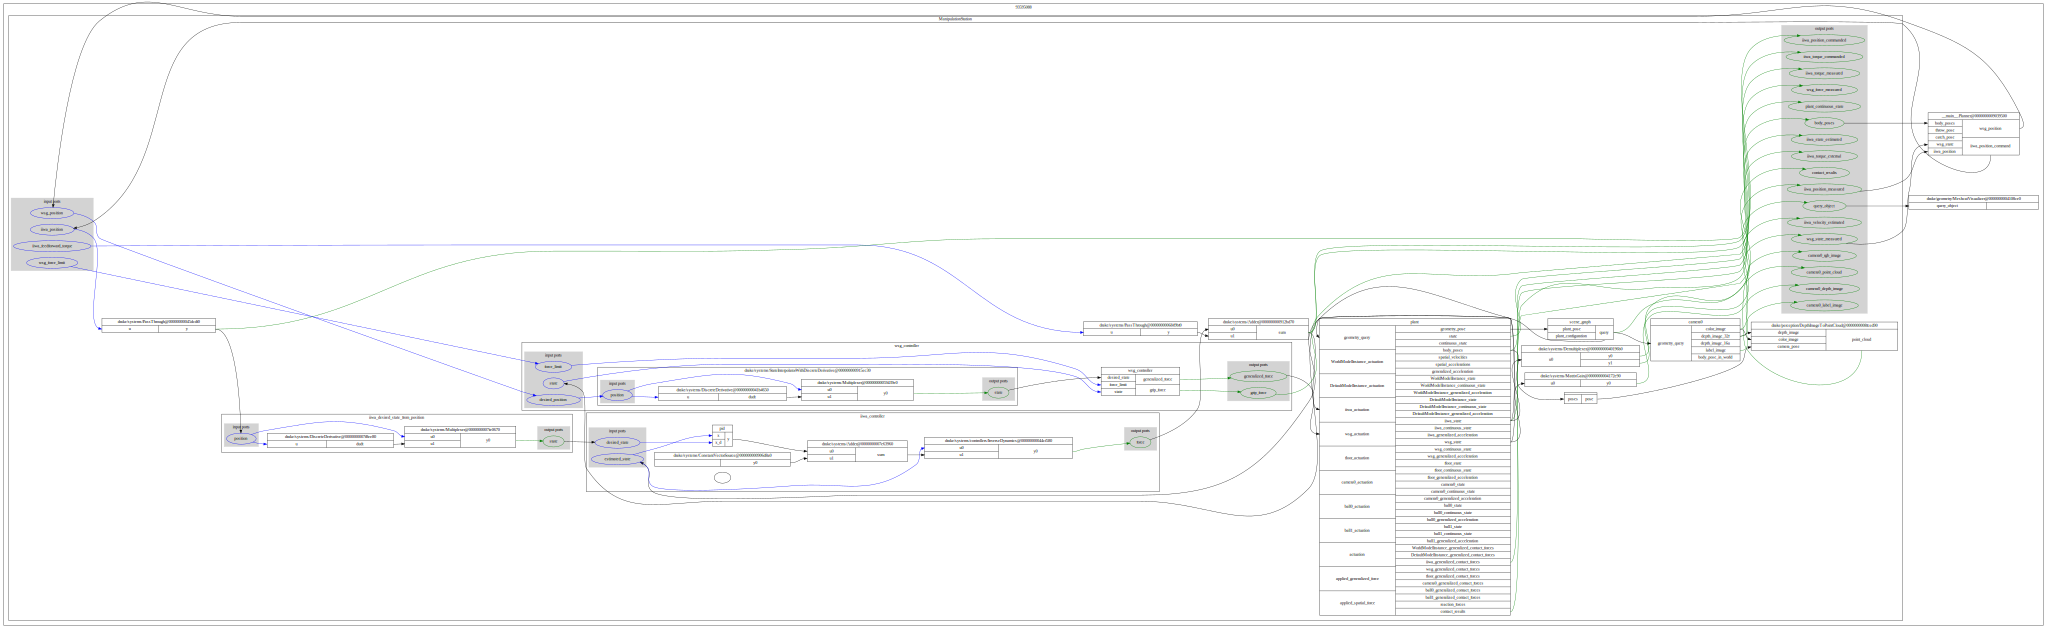

In [ ]:
def clutter_clearing_demo():
    #meshcat.Delete()
    builder = DiagramBuilder()

    model_directives = """
directives:
- add_model:
    name: iiwa
    file: package://drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf
    default_joint_positions:
        iiwa_joint_1: [-1.57]
        iiwa_joint_2: [0.1]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-1.2]
        iiwa_joint_5: [0]
        iiwa_joint_6: [ 1.6]
        iiwa_joint_7: [0]
- add_weld:
    parent: world
    child: iiwa::iiwa_link_0
- add_model:
    name: wsg
    file: package://drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_with_tip.sdf
- add_weld:
    parent: iiwa::iiwa_link_7
    child: wsg::body
    X_PC:
        translation: [0, 0, 0.09]
        rotation: !Rpy { deg: [90, 0, 90]}
- add_model:
    name: floor
    file: package://manipulation/floor.sdf
- add_weld:
    parent: world
    child: floor::box
    X_PC:
        translation: [0, 0, -.5]
- add_frame:
    name: camera0_origin
    X_PF:
        base_frame: world
        rotation: !Rpy { deg: [-130.0, 0, 90.0]}
        translation: [.25, -.5, .4]
- add_model:
    name: camera0
    file: package://manipulation/camera_box.sdf
- add_weld:
    parent: camera0_origin
    child: camera0::base
"""

    for i in range(2 if running_as_notebook else 2):
        model_directives += f"""
- add_model:
    name: ball{i}
    file: package://one_arm_juggling/models/ball.sdf
"""

    # station = builder.AddSystem(
    #     MakeManipulationStation(model_directives, package_xmls=["models/ball.sdf"], time_step=0.001))
    station = builder.AddSystem(MakeManipulationStation(model_directives, package_xmls=["./package.xml"], time_step=0.001))
    # station = builder.AddSystem(MakeManipulationStation(filename="models/cluttered.dmd.yaml", time_step=0.001))
    # station = builder.AddSystem(MakeManipulationStation(model_directives, time_step=0.001))
    plant = station.GetSubsystemByName("plant")
    # AddBall(plant, radius=0.5, name="ball_1")
    planner = builder.AddSystem(Planner(plant))
    builder.Connect(station.GetOutputPort("body_poses"),
                    planner.GetInputPort("body_poses"))
    # # TODO: another system should output the throw and catch points
    # # builder.Connect(x_bin_grasp_selector.get_output_port(),
    # #                 planner.GetInputPort("x_bin_grasp"))
    # # builder.Connect(y_bin_grasp_selector.get_output_port(),
    # #                 planner.GetInputPort("y_bin_grasp"))
    builder.Connect(station.GetOutputPort("wsg_state_measured"),
                    planner.GetInputPort("wsg_state"))
    builder.Connect(station.GetOutputPort("iiwa_position_measured"),
                    planner.GetInputPort("iiwa_position"))

    builder.Connect(planner.GetOutputPort("wsg_position"),
                    station.GetInputPort("wsg_position"))

    builder.Connect(planner.GetOutputPort("iiwa_position_command"),
                    station.GetInputPort("iiwa_position"))

    visualizer = MeshcatVisualizer.AddToBuilder(
        builder, station.GetOutputPort("query_object"), meshcat)
    diagram = builder.Build()

    simulator = Simulator(diagram)
    context = simulator.get_context()

    q_Throw = np.array([-0.54, 0.58, 0, -1.79, 0, -0.79, 0])
    p_WThrow = [0.6, -0.3, 0.39] # [0.55 -0.38 0.39]
    R_WThrow = RollPitchYaw([-np.pi, 0.00, 1.10])

    q_Catch = np.array([-0.74, 0.58, 0, -1.79, 0, -0.79, 0])
    p_WCatch = [0.50, -0.45, 0.39]
    R_WCatch = RollPitchYaw([-np.pi, 0.00, 0.84])

    X_WThrow = RigidTransform(R_WThrow, p_WThrow)
    X_WCatch = RigidTransform(R_WCatch, p_WCatch)
    add_target_objects(X_WThrow, X_WCatch)

    plant_context = plant.GetMyMutableContextFromRoot(context)
    for body_index in plant.GetFloatingBaseBodies():
        tf = RigidTransform(X_WCatch.rotation(), X_WCatch.translation() + np.array([0,0,3]))
        plant.SetFreeBodyPose(plant_context,
                              plant.get_body(body_index),
                              tf)
    
    simulator.AdvanceTo(0.1)
    meshcat.Flush()  # Wait for the large object meshes to get to meshcat.

    if running_as_notebook:
        simulator.set_target_realtime_rate(0.5)
        meshcat.AddButton("Stop Simulation", "Escape")
        print("Press Escape to stop the simulation")
        while meshcat.GetButtonClicks("Stop Simulation") < 1:
            simulator.AdvanceTo(simulator.get_context().get_time() + 2.0)
        meshcat.DeleteButton("Stop Simulation")
    
clutter_clearing_demo()

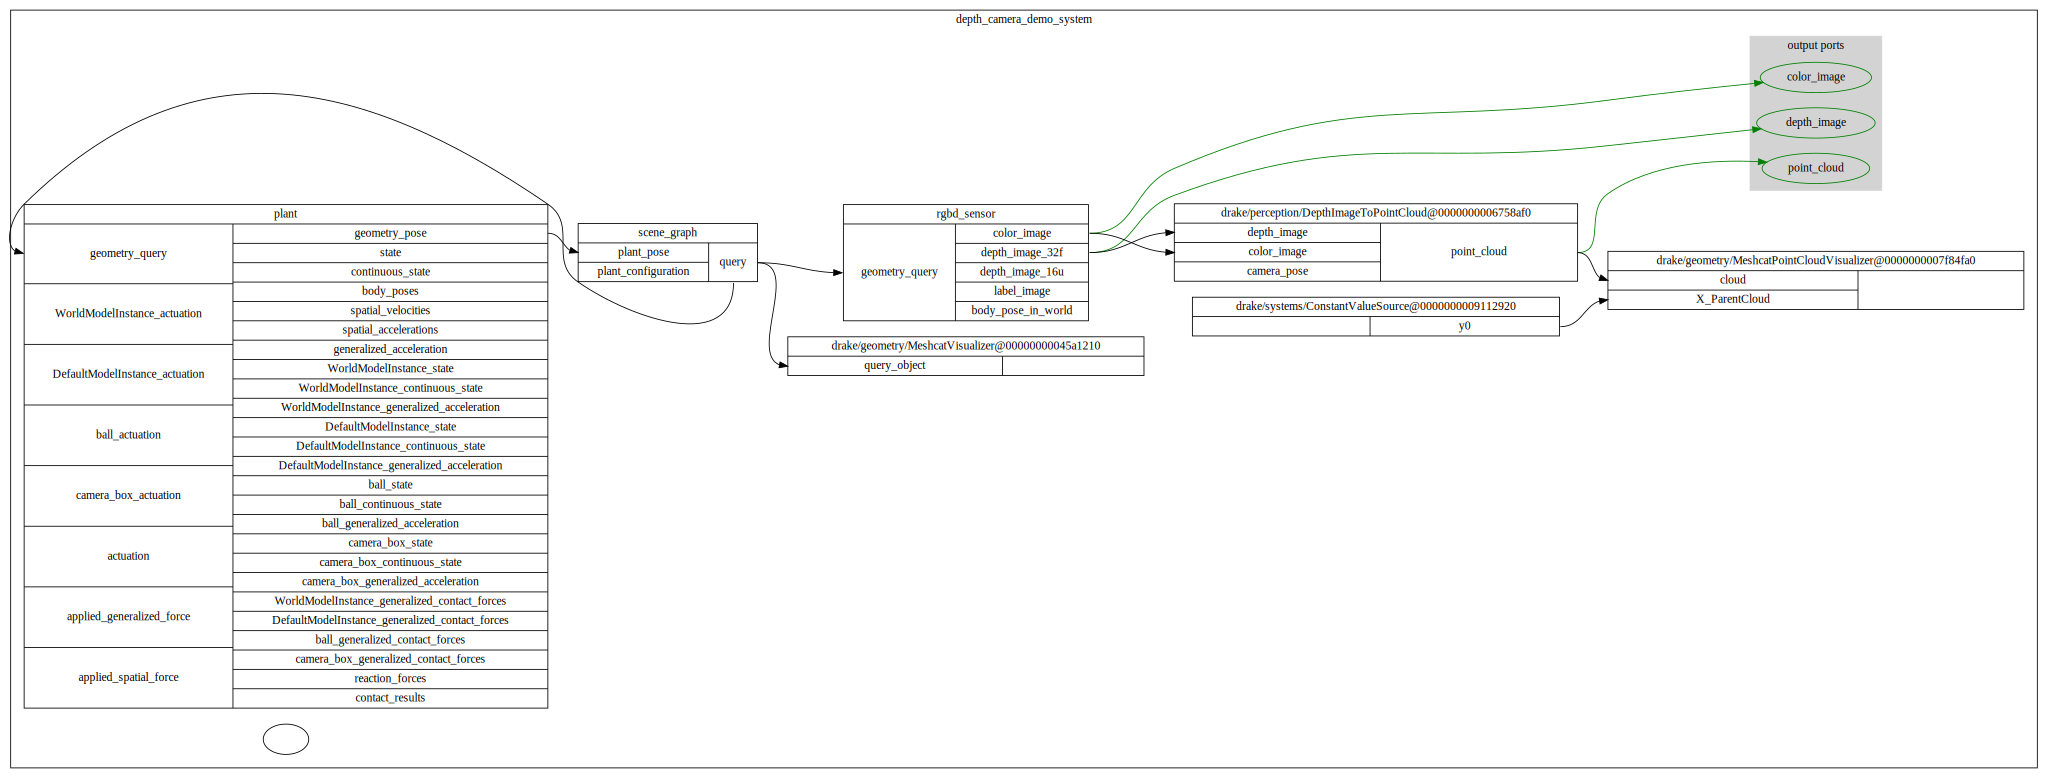

AttributeError: 'NoneType' object has no attribute 'CreateDefaultContext'

In [ ]:
def plot_camera_images():
    system = DepthCameraDemoSystem()

    # Evaluate the camera output ports to get the images.
    context = system.CreateDefaultContext()
    system.Publish(context)
    color_image = system.GetOutputPort("color_image").Eval(context)
    depth_image = system.GetOutputPort("depth_image").Eval(context)

    # Plot the two images.
    plt.subplot(121)
    plt.imshow(color_image.data)
    plt.title('Color image')
    plt.subplot(122)
    plt.imshow(np.squeeze(depth_image.data))
    plt.title('Depth image')
    #mpld3.display()
    plt.show()
plot_camera_images()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=68a898be-bd4e-4046-916a-6293aadf6c5d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>